# CENG 471 Introduction to Image Processing
## Assignment 2 - Canny Edge Detector
## Due: December 22 by 11:59pm

import library

In [337]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import skimage.io as skio
import skimage as sk
import scipy.stats as st
from scipy import ndimage
from scipy import signal

1.Grayscale Conversion

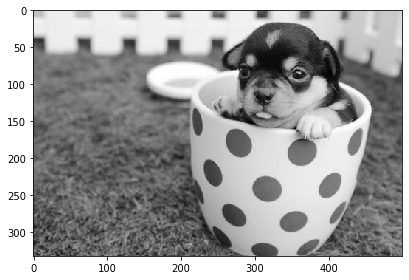

In [338]:
image= skio.imread(r'chihuahua-dog-puppy-cute-39317_small.jpeg')
grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
skio.imshow(grayscale,cmap = plt.get_cmap('gray'))
skio.show()

2. Gaussian Filter

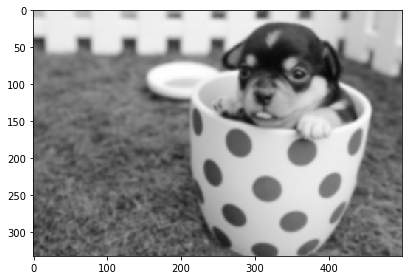

In [346]:
#Gaussian filter with using library
img_gaus = ndimage.gaussian_filter(grayscale, sigma=1.5)
skio.imshow(img_gaus, cmap = plt.get_cmap('gray'))
skio.show()

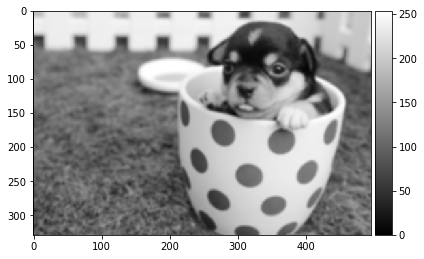

In [366]:
def gaussian_filter(kernel, sigma): 
    filter_size = (2 * sigma + 1)/(kernel)
    x = np.linspace(-sigma-filter_size/2., sigma+filter_size/2., kernel+1)
    kernel_raw = np.sqrt(np.outer(np.diff(st.norm.cdf(x)), np.diff(st.norm.cdf(x))))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel
 
def filtered(kernel,image,a):
    #filter image with kernel
    width=len(image[0])
    height=len(image)
    n=width-2*a
    m=height-2*a
    filtered_image= np.empty([m,n])
    for x in range(a,n):
        for y in range(a,m):
            filtered_image[y][x]=filterValue(kernel,image[y-a:y+a+1,x-a:x+a+1],a)
    return filtered_image


def filterValue(kernel,pixel,a):
    #filter value
    result=0
    for i in range(0,2*a+1):
        for j in range(0,2*a+1):
            result=result+kernel[i][j]*pixel[i][j]
    return result


blur=filtered(gaussian_filter(5,1.2),grayscale,2)
blur=blur.astype(int)
skio.imshow(blur,cmap = plt.get_cmap('gray'))
skio.show()

3. Find intensity gradients 

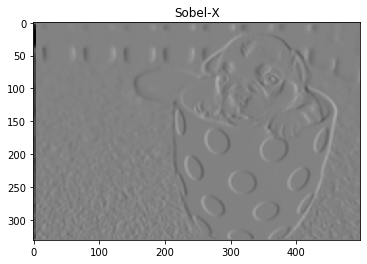

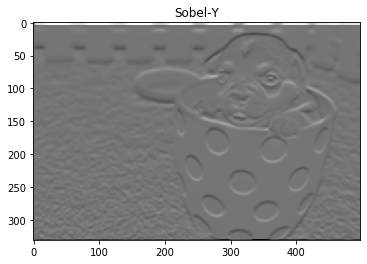

In [367]:
def sobelFilterX(image):
    #kernel x
    vertical =  np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    #convolve the image
    Ix = signal.convolve(image, vertical)
    return Ix

def sobelFilterY(image):
    #kernel y
    horizontal= np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    #convolve the image
    Iy = signal.convolve(image, horizontal)
    return Iy

#sobel filters
x=sobelFilterX(blur)

y=sobelFilterY(blur)


plt.title("Sobel-X")
plt.imshow(x, cmap = plt.get_cmap('gray'))
plt.show()

plt.title("Sobel-Y")
plt.imshow(y, cmap = plt.get_cmap('gray'))
plt.show()

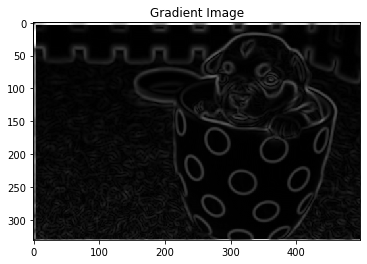

In [368]:
#gradient magnitude
gradient_image= np.sqrt(x**2+y**2)

#θ of the gradient
theta=np.arctan2(y,x)

plt.title("Gradient Image")
plt.imshow(gradient_image ,cmap = plt.get_cmap('gray'))
plt.show()

4.Non-maximum suppression

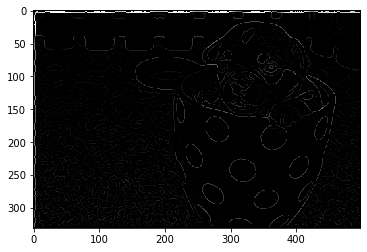

In [369]:
def non_max_suppression(img, theta):
    
    width,heigth= img.shape
    edge_image = np.zeros((width,heigth))
    
    # convert degree    
    degree = theta * 180/np.pi
    degree[degree < 0] += 180

    for i in range(1,width-1):
        for j in range(1,heigth-1):     
            
           #gradient magnitude> east and west directions, this is edge
           # 0° (nourth-south)
            if (0 <= degree[i,j] < 22.5) or (157.5 <= degree[i,j] <= 180):
                if (img[i, j] >= img[i, j - 1]) and (img[i, j] >= img[i, j + 1]):
                    edge_image[i,j] = img[i,j]

            # gradient magnitude>north-east and south-west directions, this is edge
            # 45° (north west–south)
            elif (22.5 <= degree[i,j] < 67.5):
                if (img[i, j] >= img[i - 1, j + 1]) and (img[i, j] >= img[i + 1, j - 1]):
                    edge_image[i,j] = img[i,j]
                    
            # gradient magnitude>north and south directions, this is edge
            # 90° (east-west direction)
            elif (67.5 <= degree[i,j] < 112.5):
                if (img[i, j] >= img[i - 1, j]) and (img[i, j] >= img[i + 1, j]):
                    edge_image[i,j] = img[i,j]
                    
            # gradient magnitude>north-west and south-east directions,this is edge
            # 135° (northeast-southwest direction)
            elif (112.5 <= degree[i,j] < 157.5):
                if (img[i, j] >= img[i - 1, j - 1]) and (img[i, j] >= img[i + 1, j + 1]):
                    edge_image[i,j] = img[i,j]                  
            #gradient magnitude>all of neighbors
            else:
                edge_image[i,j] = 0
    
    return edge_image


nms= non_max_suppression(gradient_image,theta)
plt.imshow(nms, cmap = plt.get_cmap('gray'))
plt.show()

5.Double threshold

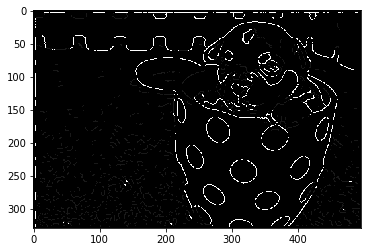

In [370]:
def double_threshold(nms):
    
    width,heigth= nms.shape
    output  = np.zeros((width,heigth),dtype=np.int32)
    
    weak = 25
    strong = 255
    
    lowThreshold = 50
    highThreshold =90
    #s>highThreshold
    strongx, strongy = np.where(nms >= highThreshold)
    #s>lowThreshold && s<highThreshold
    weakx,weaky=np.where((nms <= highThreshold) & (nms >= lowThreshold))
    
    output[strongx, strongy] = strong
    output[weakx, weaky] = weak
    
    return output


threshold= double_threshold(nms)
plt.imshow(thresholded_image, cmap='gray')
plt.show()

6.Track edge by hysteresis

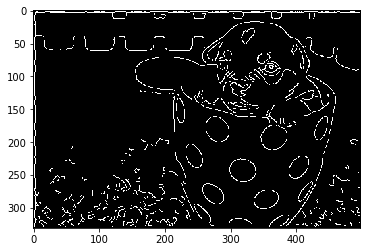

In [371]:
def track_edge_hysteresis(threshed_image):
    
    width,height= threshed_image.shape  
    for i in range(0, width):
        for j in range(0,height):
            if (threshed_image[i,j] == 25):
                if ((threshed_image[i+1, j-1] == 255) or (threshed_image[i+1, j] == 255) or (threshed_image[i+1, j+1] == 255)
                    or (threshed_image[i, j-1] == 255) or (threshed_image[i, j+1] == 255)
                    or (threshed_image[i-1, j-1] == 255) or (threshed_image[i-1, j] == 255) or (threshed_image[i-1, j+1] == 255)):
                    threshed_image[i, j] = 255
                else:
                    threshed_image[i, j] = 0

    return threshed_image

result=track_edge_hysteresis(threshold)
plt.imshow(result, cmap='gray')
plt.show()


Operation with canny function for comparison

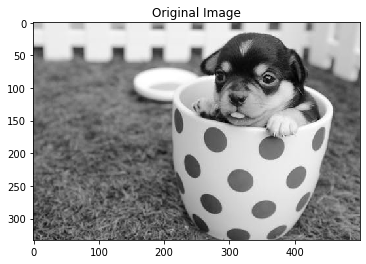

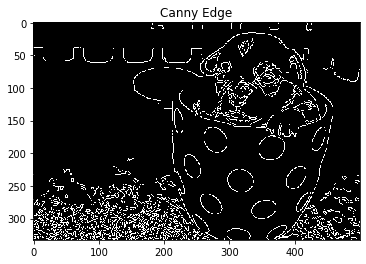

In [372]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('chihuahua-dog-puppy-cute-39317_small.jpeg',0)
edges = cv2.Canny(img,100,200)

plt.imshow(img,cmap = 'gray')
plt.title('Original Image')
plt.show() 

plt.imshow(edges,cmap = 'gray')
plt.title('Canny Edge')

plt.show() 